In [ ]:
!pip install -q datasets faiss-gpu transformers sentencepiece

In [ ]:
import os
import pandas as pd
import json
from tqdm import tqdm
from collections import defaultdict
import torch
from PIL import Image, ImageOps
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# New dataframe

In [3]:
data = pd.read_csv('/kaggle/input/cp-sochi-2024/train.csv', delimiter=';')
data.head()

,object_id,name,description,group,img_name
0,10669820,Водолей - коник (фрагмент - голова),"сероглиняный, лепной, со сплошным белым ангобо...",Археология,7862029.jpg
1,4489444,Винтовка «Самозарядная винтовка Токарева» (мет...,"На стволе имеется надульник, на торце которог...",Оружие,9461061.jpg
2,8722586,Инструмент. Калибр-скоба,Прямоугольная пластина с усечёнными углами и д...,Прочие,5095122.jpg
3,3712248,"Судомодель. НИС ""Космонавт Виктор Пацаев"".","Корпус модели, надстройки, шлюпки выполнены и...",Прочие,551422.jpg
4,6339754,Сабля.,NaN,Оружие,2592073.jpg


In [4]:
# словарь объект - картинка
dict_object_image = data.groupby('object_id')['img_name'].apply(lambda x: list(x)[0]).to_dict()

In [7]:
# получаем пути до jpg файлов
def find_jpg_files(directory):
    jpg_files = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.jpg') and filename in dict_object_image.values():
                jpg_files.append(os.path.join(dirpath, filename))
    return jpg_files


directory_path = 'train'
jpg_files = find_jpg_files(directory_path)
for jpg_file in jpg_files[:3]:
    print(jpg_file)

/kaggle/input/cp-sochi-2024/train/37305961/44824650.jpg
/kaggle/input/cp-sochi-2024/train/10910697/8198185.jpg
/kaggle/input/cp-sochi-2024/train/24378296/26831022.jpg


In [10]:
# делаем словарь 
# {object_id: [img_id, img_id]}
new_dict = defaultdict(list)

for file in jpg_files:
    object_id = file.split('/')[-2]
    image_id = file.split('/')[-1]
    
    new_dict[object_id].append(image_id)

In [11]:
# удостоверимся, что кол-во одинаковое
len(jpg_files), len(new_dict), data['object_id'].nunique()

(16430, 16430, 16430)

In [12]:
# обхеденим информацию
new_dataframe = pd.DataFrame({'image_id': dict_object_image.values()})
new_dataframe = new_dataframe.merge(data, how='left', left_on='image_id', right_on='img_name')
new_dataframe.drop('image_id', axis=1, inplace=True)
new_dataframe.drop_duplicates(subset='img_name', inplace=True)
new_dataframe['all_images'] = new_dataframe['object_id'].apply(lambda x: new_dict[str(x)])
new_dataframe['object_id'] = new_dataframe['object_id'].astype('str')

In [13]:
new_dataframe.head(3)

,object_id,name,description,group,img_name,all_images
0,83137,Картина. Натюрморт,Изображение букета цветов в керамическом кувши...,Живопись,20110231.jpg,[20110231.jpg]
1,85587,Портрет молящейся крестьянки. Копия с картины ...,"Изображение молодой женщины, победренное, в пр...",Живопись,20110220.jpg,[20110220.jpg]
2,85658,Икона. Избранные святые,"Доска из трех частей, две врезные встречные шп...",Живопись,23441576.jpg,[23441576.jpg]


In [14]:
# отсортируем одинаково датафрейм и список с путями до файлов
# это нужно для корректной работы FAISS
jpg_files.sort(key=lambda x: x.split('/')[-2])

new_dataframe.sort_values(by='object_id', inplace=True)
new_dataframe.reset_index(drop=True, inplace=True)

In [15]:
jpg_files[-5:]

['/kaggle/input/cp-sochi-2024/train/9992989/6864639.jpg',
 '/kaggle/input/cp-sochi-2024/train/9993000/6864663.jpg',
 '/kaggle/input/cp-sochi-2024/train/9993006/6864675.jpg',
 '/kaggle/input/cp-sochi-2024/train/9994312/6866451.jpg',
 '/kaggle/input/cp-sochi-2024/train/9999965/27844178.jpg']

In [16]:
new_dataframe.tail()

,object_id,name,description,group,img_name,all_images
16425,9992989,Раковина. Морской моллюск,"Раковина овально-треугольная выпуклая, белая.",Естественнонауч.коллекция,6864639.jpg,[6864639.jpg]
16426,9993000,"Морской моллюск. Раковина ""Конус эбреус""",Раковина Конус эбреус. Раковина обратно- конич...,Естественнонауч.коллекция,6864663.jpg,[6864663.jpg]
16427,9993006,Раковина. Морской моллюск,Раковина. Арка. Створка раковины толстостенна...,Естественнонауч.коллекция,6864675.jpg,[6864675.jpg]
16428,9994312,Морской моллюск. Раковина мактры овальной,"Раковина прочная, округло - овальная, вздутая,...",Естественнонауч.коллекция,6866451.jpg,[6866451.jpg]
16429,9999965,Револьвер типа «британский бульдог».,NaN,Оружие,27844178.jpg,[27844178.jpg]


In [17]:
# проверили, что пути и датафрейм отсортированы правильно (1 img_name = 1 путь до файла в jpg_files)

In [18]:
len(new_dataframe), len(jpg_files)

(16430, 16430)

# FAISS

## CLIP

In [21]:
model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [22]:
# для примера и экономии времени здесь возьмем только тысячу экспонатов
# в системе уже используется поиск по всем

test_jpg_files = jpg_files[:1000]
test_dataframe = new_dataframe[:1000]
test_dataframe.to_csv('test.csv', index=False)

In [23]:
len(test_dataframe), len(test_jpg_files)

(1000, 1000)

In [24]:
%%time
# получаем эмбеддинги с помощью CLIP


embeddings = []

for image_path in tqdm(test_jpg_files):
    
    image = Image.open(image_path)
    img_embedding = (
        model.get_image_features(**processor([image], return_tensors="pt").to("cuda"))[0]
        .detach()
        .cpu()
        .numpy()
    )
    
    embeddings.append(img_embedding)

embeddings = np.array(embeddings)

100%|██████████| 1000/1000 [01:13<00:00, 13.53it/s]

CPU times: user 1min 9s, sys: 7.16 s, total: 1min 17s
Wall time: 1min 13s


In [26]:
# добавляем FAISS индекс и сохраняем его

d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)
faiss.write_index(index, "faiss.index")


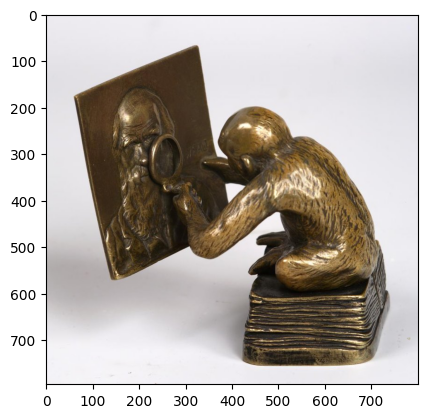

In [47]:
# возьмем случайный экспонат
image = Image.open(test_jpg_files[80])

# отзеркалим изображение, для имитации реального поиска
image = ImageOps.mirror(image)

# получим эмбеддинг этого изображения
img_embedding = (
    model.get_image_features(**processor([image], return_tensors="pt").to("cuda"))[0]
    .detach()
    .cpu()
    .numpy()
)
plt.imshow(image)

In [48]:
search_embed = np.array([img_embedding])

In [56]:
%%time

# проведем поиск в FAISS
# ищется, как видете, молниеносно
D, I = index.search(search_embed, 10)


CPU times: user 1.14 ms, sys: 885 µs, total: 2.03 ms
Wall time: 877 µs


In [57]:
# посмотрим на индексы топ 10 похожих
# как видим топ 1 - та же картинка
I

array([[ 80,  76, 729, 302, 792, 956, 665, 790, 307, 735]])

In [50]:
# а также на расстояния до них
# расстояние до исходного в 10 раз меньше чем для других похожих
D

array([[ 5.0547743, 51.230206 , 52.058186 , 52.349327 , 53.052303 ,
        53.41597  , 53.602886 , 53.725655 , 53.743504 , 54.93745  ]],
      dtype=float32)

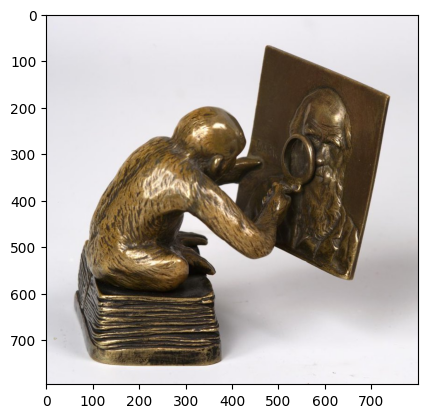

In [61]:
# топ 1 в поиске (тот же экспонат)
image = Image.open(test_jpg_files[80])
plt.imshow(image)

<Figure size 640x480 with 0 Axes>

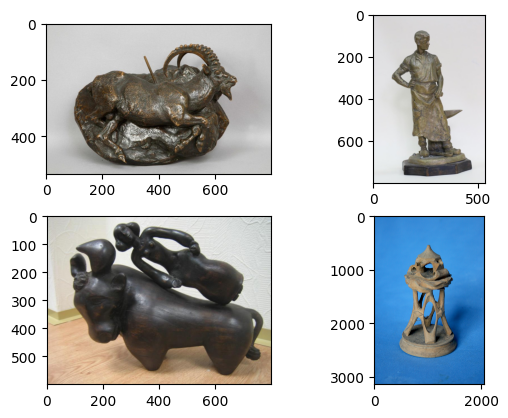

In [59]:
# также несложно заметить, что другие экспонаты из топ 10
# достаточно сильно похожи на исходный, что подтвержает качество поиска


plt.figure()

f, axarr = plt.subplots(2, 2) 
axarr[0, 0].imshow(Image.open(test_jpg_files[76]))
axarr[0, 1].imshow(Image.open(test_jpg_files[729]))
axarr[1, 0].imshow(Image.open(test_jpg_files[302]))
axarr[1, 1].imshow(Image.open(test_jpg_files[792]))

In [45]:
# определим функцию для добавления нового экспоната в базу данных

def append_to_faiss_index(test_df, faiss_index, image, name, group, description=None, object_id=None, img_name=None)  -> (pd.DataFrame, faiss.swigfaiss.IndexFlatL2):
    
    # for pandas
    object_id = object_id if object_id else str(uuid.uuid4())
    img_name = img_name if img_name else str(uuid.uuid4())
    
    row = pd.DataFrame({'object_id': [object_id], 'name': [name], 'group': [group],
                        'description': [description], 'img_name': [img_name]})
    
    test_df = pd.concat([test_df, row], ignore_index=True)
    
    # for faiss
    img_embedding = (
        model.get_image_features(**processor([image], return_tensors="pt").to("cuda"))[0]
        .detach()
        .cpu()
        .numpy()
    )
    img_embedding = np.array([img_embedding])
    faiss_index.add(img_embedding)
    
    
    return test_df, faiss_index
    


In [46]:
# при желании можно добавить новый экспонат в индексацию

# test_dataframe, index = append_to_faiss_index(test_dataframe, index, image, 'Статуя М.И. Кутузова', 'прочие')
# test_dataframe.to_csv('...')
# faiss.write_index(index, "faiss.index")


# Final function

In [ ]:
# финальные функции для быстрого получения похожих объектов и их описания

In [48]:
def get_relevant_objects(images, index, test_dataframe, model, processor, k=10) -> pd.DataFrame:
    device = "cpu"
    img_embeddings = [(
            model.get_image_features(**processor([image], return_tensors="pt").to(device))[0]
            .detach()
            .cpu()
            .numpy()
        ) for image in images]
    
    search_embed = np.mean(np.array([img_embeddings]), axis=1)

    distances, indexes = index.search(search_embed, k)
    
    return test_dataframe.iloc[indexes[0]]

In [49]:
# model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
# processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [50]:
# загружаем картинку
paths_to_images = [test_jpg_files[12]]
images = [Image.open(path) for path in paths_to_images]

# загружаем FAISS индекс и датафрейм
faiss_index = faiss.read_index("faiss.index")
test_dataframe = pd.read_csv('test.csv')

In [61]:
# классифицируем группу объекта
def get_group(result_df: pd.DataFrame) -> str:
    return result_df['group'].mode().values[0]

result_df = get_relevant_objects(images, faiss_index, test_dataframe, model, processor)
get_group(result_df)

'Фото, негативы'

In [58]:
# и классифицируем правильно
result_df['group'].mode().values[0]

'Фото, негативы'

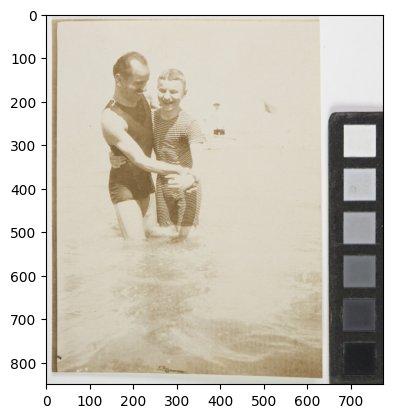

In [53]:
plt.imshow(Image.open(test_jpg_files[68]))